# Importing Data and Dependencies

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.all import *
from fastai.vision.all import *

!pip install -Uqq fastkaggle --no-index --find-links=file:///kaggle/input/library-fastkaggle/
from fastkaggle import *

from shutil import copyfile
copyfile(src = "../input/isic-vision/isic_helper.py", dst = "../working/isic_helper.py")
from isic_helper import *

In [2]:
path = setup_comp('isic-2024-challenge')
path.ls()

(#6) [Path('../input/isic-2024-challenge/sample_submission.csv'),Path('../input/isic-2024-challenge/train-metadata.csv'),Path('../input/isic-2024-challenge/test-metadata.csv'),Path('../input/isic-2024-challenge/test-image.hdf5'),Path('../input/isic-2024-challenge/train-image'),Path('../input/isic-2024-challenge/train-image.hdf5')]

In [3]:
df = pd.read_csv(path/'train-metadata.csv', low_memory=False)
test_df = pd.read_csv(path/'test-metadata.csv', low_memory=False)

df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

# Data Preparation

In [5]:
features = list(test_df.drop(columns=["isic_id","image_type","copyright_license"]).columns)
X, y = df[features], df.target

In [6]:
def add_lesion_count(X):
    n_lesion = X["patient_id"].value_counts()
    X.loc[:,"n_lesion"] = n_lesion[X["patient_id"]].values
    X.drop(columns="patient_id", inplace=True)
    return X

In [7]:
groups = X.patient_id
X = add_lesion_count(X.copy())

In [8]:
oof_preds = pd.read_csv('/kaggle/input/isic-vision/vision_oof_preds')
X.loc[:,'vision_preds'] = oof_preds.vision_preds

In [9]:
def sample_train_idx(train_idx):
    train_idx = np.array(train_idx)
    train_idx = sample(train_idx, df, do_up=False, ratio=1/300)
    train_idx = sample(train_idx, df, do_up=True, ratio=2/3)
    return list(train_idx)

In [10]:
def preprocess(X, split):
    procs = [FillMissing, Categorify]
    cont, cat = cont_cat_split(X)
    to = TabularPandas(X, procs, cat, cont, splits=split)
    return cat, to.train.xs, to.valid.xs

# Cross-Validation

In [11]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(5, shuffle=True)

In [12]:
lgb_params = {'objective':        'binary',
              'verbosity':        -1,
              'n_iter':           234,
              'boosting_type':    'gbdt',
              'lambda_l1':        0.08758718919397321, 
              'lambda_l2':        0.0039689175176025465, 
              'learning_rate':    0.03231007103195577, 
              'max_depth':        4, 
              'num_leaves':       103, 
              'colsample_bytree': 0.8329551585827726, 
              'colsample_bynode': 0.4025961355653304, 
              'bagging_fraction': 0.7738954452473223, 
              'bagging_freq':     4, 
              'min_data_in_leaf': 85, 
              'scale_pos_weight': 2/3}

In [13]:
cb_params = {'loss_function':     'Logloss',
             'iterations':        250,
             'verbose':           False,
             'max_depth':         7, 
             'learning_rate':     0.06936242010150652, 
             'scale_pos_weight':  2/3, 
             'l2_leaf_reg':       6.216113851699493, 
             'subsample':         0.6249261779711819, 
             'min_data_in_leaf':  24,
             'cat_features':      'na'}

In [14]:
xgb_params = {'eta':                0.03, 
              'reg_lambda':         8.9, 
              'alpha':              0.7,
              'subsample':          0.6, 
              'colsample_bytree':   0.85, 
              'colsample_bylevel':  0.55,
              'scale_pos_weight':   2/3,
              'max_delta_step':     3}

In [15]:
from sklearn.metrics import confusion_matrix

def calc_metrics(m, X, y, thresh=0.5):
    probs = m.predict_proba(X)[:,1]
    pAUC = p_AUC(y, probs)
    preds = (probs>=thresh).astype('int')
    cm = confusion_matrix(y, preds)
    return pAUC, cm

In [16]:
from lightgbm import LGBMClassifier as lgb
from catboost import CatBoostClassifier as cb
from xgboost import XGBClassifier as xgb
from sklearn.ensemble import VotingClassifier as voting

pAUC, cm = [],[]
for train_idx,valid_idx in sgkf.split(X, y, groups):
    train_idx = sample_train_idx(train_idx)
    split = list(train_idx), list(valid_idx)
    cat, train_X, valid_X = preprocess(X, split)
    train_y, valid_y = y[train_idx], y[valid_idx]
    
    m_lgb = lgb(**lgb_params)
    cb_params['cat_features'] = cat
    m_cb = cb(**cb_params)
    m_xgb = xgb(**xgb_params)
    estimator = voting([('lgb', m_lgb), ('cb', m_cb),
                        ('xgb', m_xgb)], voting='soft')
    estimator.fit(train_X, train_y)
    
    train_pAUC, train_cm = calc_metrics(estimator, train_X, train_y)
    valid_pAUC, valid_cm = calc_metrics(estimator, valid_X, valid_y)
    pAUC.append((train_pAUC, valid_pAUC))
    cm.append((train_cm, valid_cm))

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained

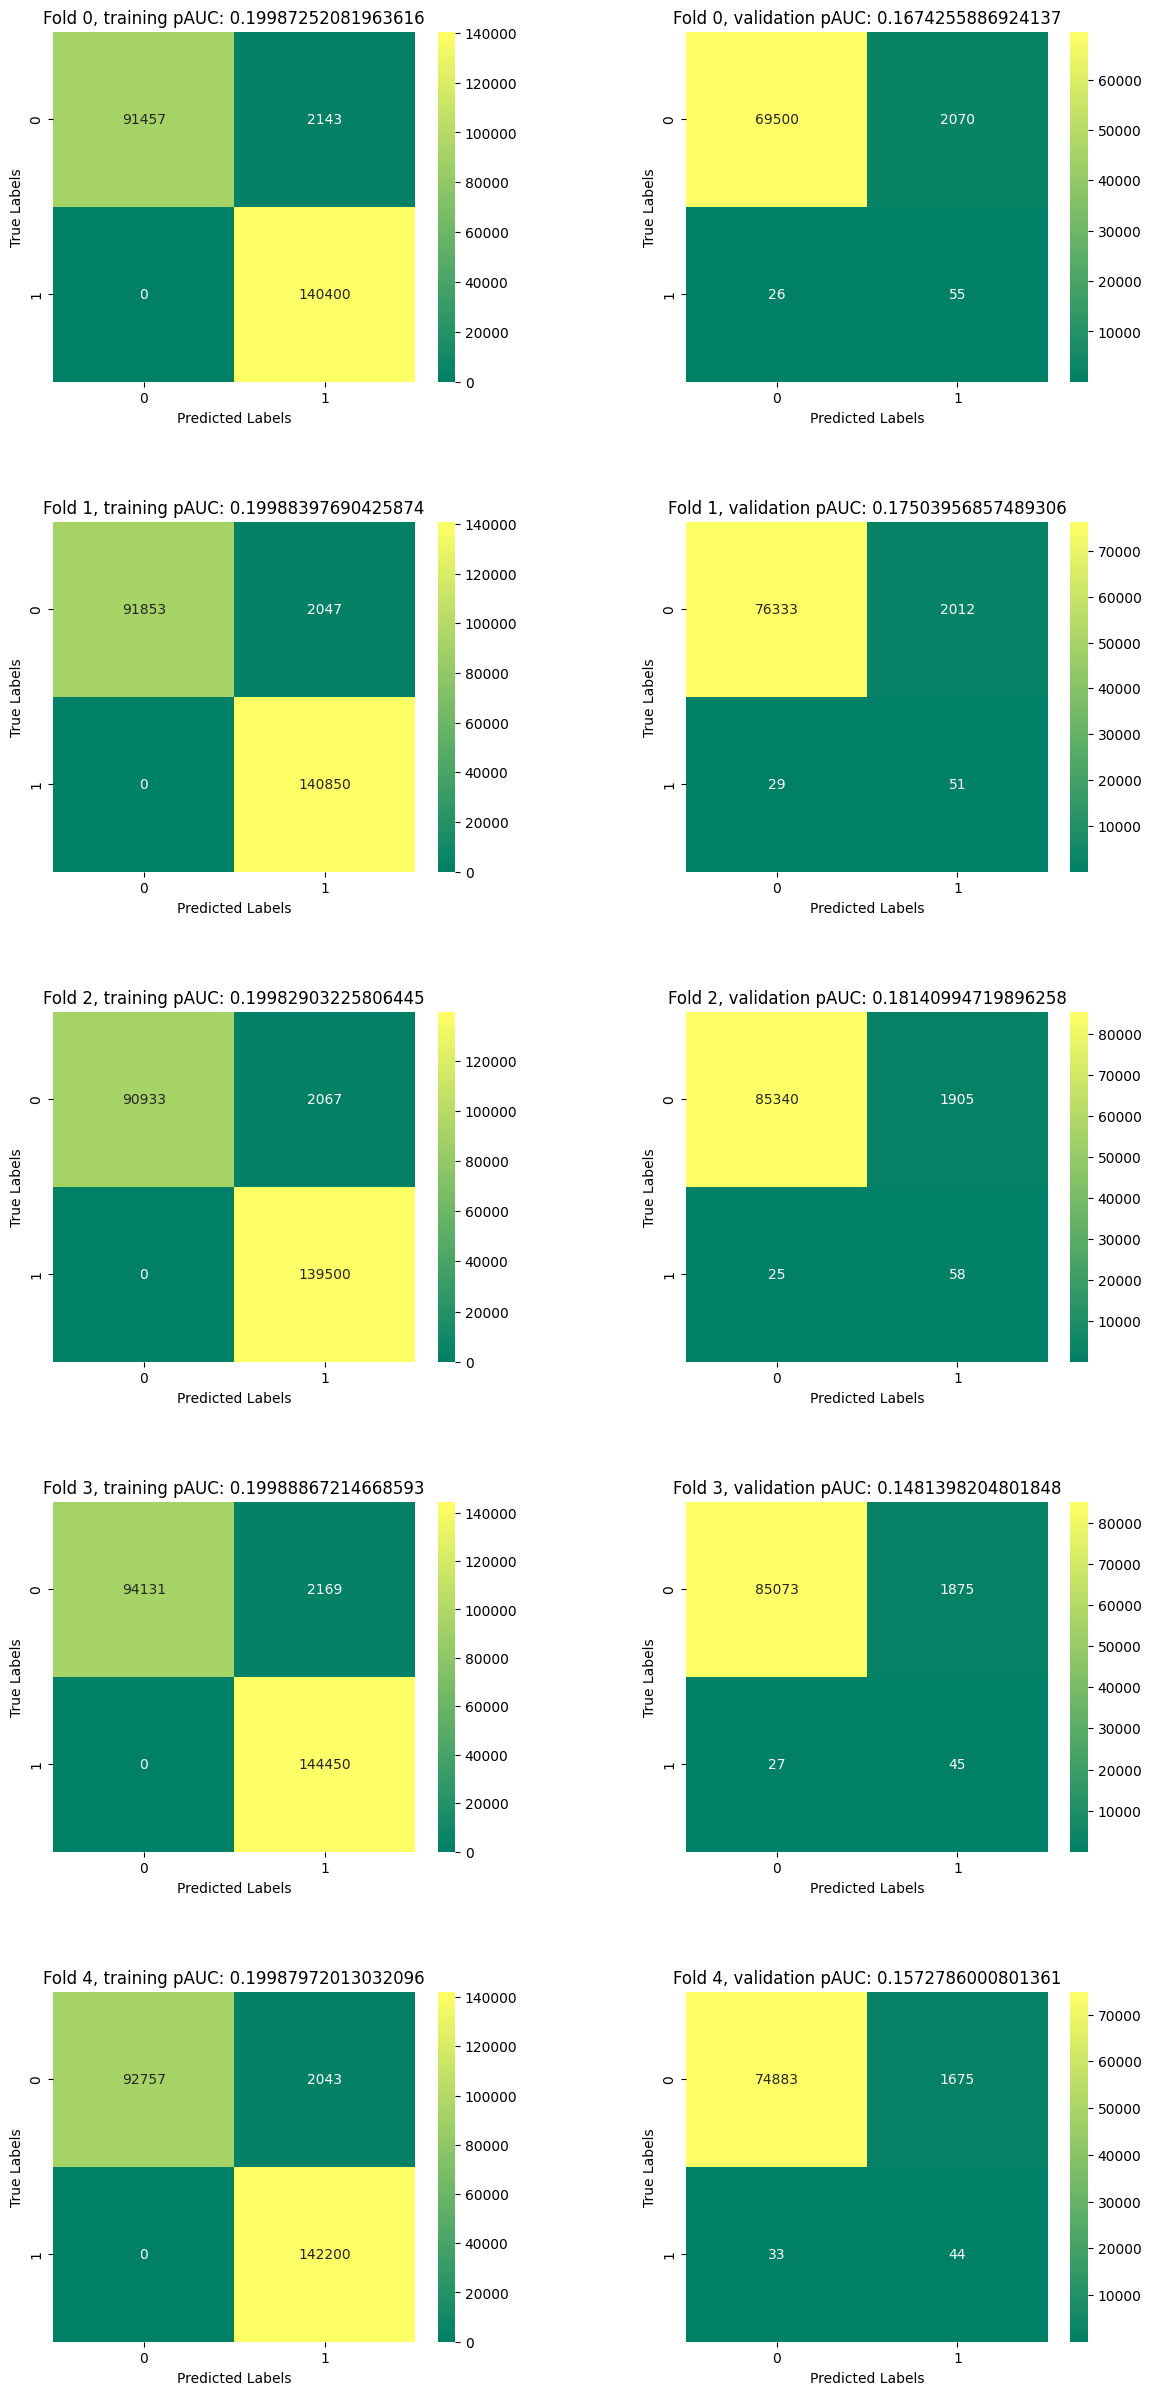

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

_, axs = plt.subplots(len(cm), 2, figsize=(14, len(cm)*6))
for i, ax in enumerate(axs):
    sns.heatmap(cm[i][0], annot=True, fmt='d', cmap='summer', ax=ax[0])
    ax[0].set_title(f'Fold {i}, training pAUC: {pAUC[i][0]}')
    ax[0].set_xlabel('Predicted Labels')
    ax[0].set_ylabel('True Labels')

    sns.heatmap(cm[i][1], annot=True, fmt='d', cmap='summer', ax=ax[1])
    ax[1].set_title(f'Fold {i}, validation pAUC: {pAUC[i][1]}')
    ax[1].set_xlabel('Predicted Labels')
    ax[1].set_ylabel('True Labels')

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [18]:
valid_pAUC = 0
for _,score in pAUC: valid_pAUC += score
valid_pAUC /= 5

valid_pAUC

0.16585870500531805

# Get test predictions from image model

In [19]:
img_path = path/'train-image.hdf5'
test_img_path = path/'test-image.hdf5'

imgs_data = get_img_data(img_path, test_img_path, df)

Reading test files: 100%|██████████| 3/3 [00:00<00:00, 262.49it/s]


In [20]:
def get_items(path): return df.isic_id

def get_x(key): return PILImage.create(imgs_data[key][0])

def get_y(key): return imgs_data[key][1]

def loss_func(targs, preds): return flat_BCE_with_logits(targs, preds, ratio=3/2)

In [21]:
learn = load_learner("../input/isic-vision/fitted_resnet18.pkl", cpu=False)

In [22]:
test_keys = list(test_df.isic_id)
test_dl = learn.dls.test_dl(test_keys, with_labels=False, bs=256)

vision_test_preds = learn.tta(dl=test_dl)[0]

# Submission

In [23]:
procs = [FillMissing, Categorify]
cont, cat = cont_cat_split(X)
to = TabularPandas(X, procs, cat, cont)
X = to.train.xs

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [24]:
m_lgb = lgb(**lgb_params)
cb_params['cat_features'] = cat
m_cb = cb(**cb_params)
m_xgb = xgb(**xgb_params)
estimator = voting([('lgb', m_lgb), ('cb', m_cb),
                    ('xgb', m_xgb)], voting='soft')
estimator.fit(X, y)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(bagging_fraction=0.7738954452473223,
                                             bagging_freq=4,
                                             colsample_bynode=0.4025961355653304,
                                             colsample_bytree=0.8329551585827726,
                                             lambda_l1=0.08758718919397321,
                                             lambda_l2=0.0039689175176025465,
                                             learning_rate=0.03231007103195577,
                                             max_depth=4, min_data_in_leaf=85,
                                             n_iter=234, num_leaves=103,
                                             objective='binary',
                                             sca...
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=3, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None, ...))],
                 voting='soft')

In [25]:
# pd.DataFrame({'cols':X.columns, 'imp':m_xgb.feature_importances_}).sort_values('imp', ascending=False)

In [26]:
tst = test_df[features]
tst = add_lesion_count(tst.copy())
tst.loc[:,'vision_preds'] = vision_test_preds.numpy().reshape(-1)

tst = to.train.new(tst)
tst.process()

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [27]:
tst = tst[X.columns]
test_probs = estimator.predict_proba(tst)[:,1]

In [28]:
submission = pd.DataFrame({'isic_id':test_df["isic_id"],'target':test_probs})
submission.to_csv('submission.csv', index=False)

In [29]:
!head submission.csv

isic_id,target
ISIC_0015657,0.0024600211858772213
ISIC_0015729,0.0020845297806775065
ISIC_0015740,0.0021494106798890323
